In [109]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib as mpl
import itertools as it


#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import scipy as sp
import numpy as np
import pandas as pd
import os
import sys  

root = os.getcwd() + "/.."
sys.path.insert(0, root)

import src.positioning_sensors as ps
import src.regionGrowing as rg
import src.manageExperiments as me
import src.network_fitness as netfit

importlib.reload(ps)
importlib.reload(rg)
importlib.reload(me)
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga



import config.config as cfg
importlib.reload(cfg)


<module 'config.config' from '/Users/rodrigo/Documents/SourcesCodes/GitHub/optimization_sensor_locations_results/notebooks/../config/config.py'>

In [110]:
#fn = "bratislava_experiment.txt"
#setup = me.readConfigFile(fn)

fn = "linz_with_init_net.txt"
setup = me.readConfigFile(fn)

In [111]:

#Loading precalculated local and directed empirical variograms

filesv = (cfg.experiment + setup["experiment_id"] 
          + setup["folder_semivariances"] 
          + setup["output_semivariances"] 
          + ".csv"
         )

filesvmask = (cfg.experiment + setup["experiment_id"] 
              + setup["folder_semivariances"] 
              + setup["output_semivariances"] 
              + "mask.csv"
             )

OptimumValues = (cfg.experiment + setup["experiment_id"] 
                 + setup["folder_output"] 
                 + setup["output_values"]
                )

arguments = (cfg.experiment + setup["experiment_id"] 
             + setup["folder_output"] 
             + setup["output_args"]
            )


data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)
variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])



In [112]:

#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"] + setup["input_ntli"]
niveles = setup["folder_input"] + setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x = setup['filterg_sx']
sigma = [sigma_y, sigma_x]


#NLTI: luminance
DNTLI = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles, invert = True)
EAM[EAM==254]=1.0

#DNTLI, b = ps.desaturate(luminance, th = int(setup["desaturation_th"]))

variograms = variogram_set.reshape(len(variogram_set), 
                                   DNTLI.shape[0], 
                                   DNTLI.shape[1]
                                  )
variograms_m = variogram_set_m.reshape(len(variogram_set), 
                                       DNTLI.shape[0],DNTLI.shape[1])

coords = np.array(data.iloc[:, 1:3])

FDNTLI = sp.ndimage.gaussian_filter(DNTLI, sigma, 
                                    mode = setup['gaussian_mode']
                                   )

FDNTLI = (FDNTLI >= setup['neglect_values'])*FDNTLI

EAM = (EAM==254)*1
sensitivity = ps.f5(FDNTLI, EAM, 64)

 W = i*a^(p)


In [113]:
#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"] + setup["input_ntli"]
niveles = setup["folder_input"] + setup["input_evm"]
sigma_y = setup['filterg_sy']
sigma_x = setup['filterg_sx']
sigma = [sigma_y,sigma_x]


In [114]:
coords[0]

array([ 8, 56])

In [115]:
plt.imshow(EAM)

In [116]:
plt.imshow(variograms_m[6])

In [117]:

plt.imshow(sensitivity)

In [118]:
EAM

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [119]:

aptitude = netfit.NetworkFitness(FDNTLI, EAM, sensitivity, variograms, variograms_m, coords)
aptitude.selectFitnessFunction("max")


Selct cost functions: 
 'xor','max' or 'cover'


In [120]:

#for c in setup["sensitivity_c"]:
#    S = ps.f5(FDNTLI,EAM,c)
#    scientific_notation="{:2.4e}".format(np.sum(S*(FDNTLI>0)))
#    print(scientific_notation)


In [121]:
#res_df= pd.DataFrame(results)
#res_df.to_csv("results_7x7.csv")
res_read = pd.read_csv(OptimumValues)
rr = np.array(res_read)
r = list([])
n_init_loc = 5
for i, j in enumerate(rr):
    print(i, j)
    r.append(j[1:(1 + n_init_loc*2) + (i + 1)*2])

0 [ 0. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. nan nan nan nan nan nan nan
 nan nan nan nan nan]
1 [ 1. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. 49.  2. nan nan nan nan nan
 nan nan nan nan nan]
2 [ 2. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. 49.  2. 40. 29. nan nan nan
 nan nan nan nan nan]
3 [ 3. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. 40. 29. 42. 57. 49.  2. nan
 nan nan nan nan nan]
4 [ 4. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. 38. 32. 37. 42. 42. 57. 49.
  2. nan nan nan nan]
5 [ 5. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. 41. 19. 34. 57. 53. 50. 43.
 29. 49.  2. nan nan]
6 [ 6. 34. 34. 34. 31. 35. 29. 36. 39. 39. 22. 37. 42. 54. 22. 61. 47. 42.
 57. 40. 36. 49.  2.]


In [122]:

R = (aptitude.project(r[0][:-2])+(FDNTLI>0)*1).astype(int)


In [123]:
plt.imshow(R)

In [124]:
plt.imshow(aptitude.project(r[1]))

In [125]:
np.unique(R.flatten())

array([0, 1, 2, 3, 4, 5, 6])

In [151]:
def plotSolutions(p, img, contrast = True):

    z = np.copy(img)
    cs = int(9)

    a = p.reshape(-1,2)
    for b in a:
        c = b.astype(int)
        z[tuple(c)] = cs
        if contrast:
            z[tuple(c)] = 2
            z[tuple([c[0]+1,c[1]])]=cs
            z[tuple([c[0]+1,c[1]+1])]=cs
            z[tuple([c[0],c[1]+1])]=cs
            z[tuple([c[0]-1,c[1]-1])]=cs
            z[tuple([c[0]-1,c[1]])]=cs
            z[tuple([c[0]-1,c[1]+1])]=cs
            z[tuple([c[0],c[1]-1])]=cs
            z[tuple([c[0]+1,c[1]-1])]=cs
        

    return z

P = plotSolutions(r[5],sensitivity,False)
plt.imshow(P)

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/2807692263.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


In [127]:
R = plotSolutions(r[1], (FDNTLI>0)*1, False).astype(int)   

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/252085947.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


In [128]:
P = plotSolutions(r[1][:], FDNTLI==0, False)
plt.imshow(P)

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/252085947.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


In [141]:
plt.imshow(aptitude.project(r[2])*0+P)

In [139]:
plt.imshow(aptitude.project(r[2])+P)

In [140]:
from matplotlib.pyplot import figure

#figure(figsize=(100, 100), dpi=80)
plt.rcParams["figure.figsize"] = [100, 100]
fig, ax = plt.subplots()
M = aptitude.project(r[5])+P*10

im = ax.imshow(M)

# We want to show all ticks...
#ax.set_xticks(np.arange(len(farmers)))
#ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
#ax.set_xticklabels(farmers)
#ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.figure(figsize = (100,100))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        text = ax.text(j, i, M[i, j],
                       ha="center", va="center", color="w", fontsize=24*2)

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

<Figure size 10000x10000 with 0 Axes>

In [132]:
def f(X,Z,Par):
    return X+Z+Par


cell1 = f
cell2 = f

cell(1,2,4)

7

In [143]:
ix = 0 
R = (aptitude.project(r[ix][:]))
PS = plotSolutions(r[ix][:], R)

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/252085947.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


In [144]:
plt.imshow(R)

In [146]:
P = plotSolutions(r[ix][:], R)

plt.imshow(P)

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/252085947.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


In [136]:
R = plotSolutions(r[1], (FDNTLI>0)*1).astype(int)   

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/252085947.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


In [137]:
r[1]

array([34., 34., 34., 31., 35., 29., 36., 39., 39., 22., 49.,  2., nan,
       nan])

/var/folders/k9/wpfgnz550_n_k3t9tg8scnlw0000gn/T/ipykernel_75281/252085947.py:8: RuntimeWarning: invalid value encountered in cast
  c = b.astype(int)


IndexError: index 62 is out of bounds for axis 0 with size 62

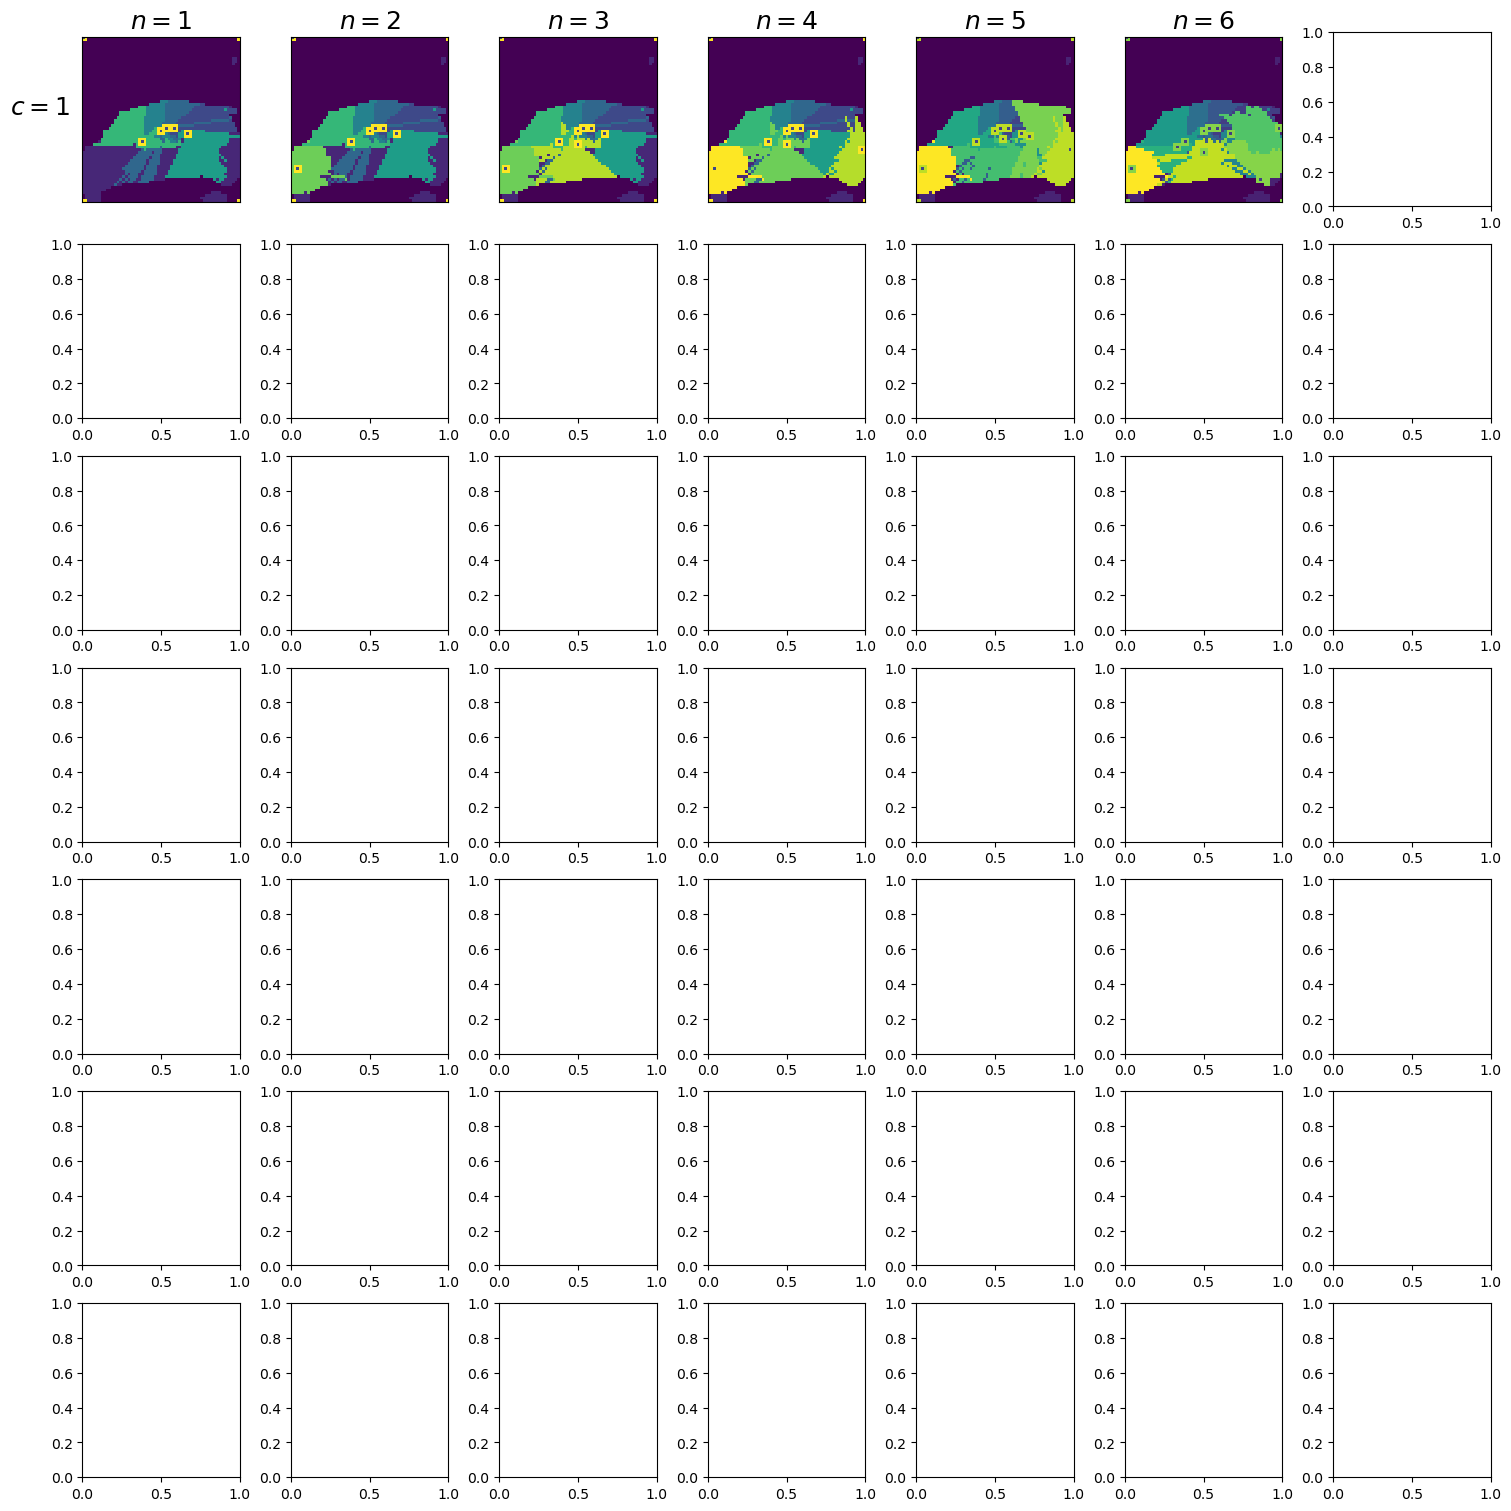

In [138]:

fig, axs = plt.subplots(ncols=7, nrows=7, figsize=(15, 15),constrained_layout=True)

# add an artist, in this case a nice label in the middle...
ix = 0
saveR = np.zeros(R.shape)
f = 0
c = setup["sensitivity_c"]
for row in range(len(c)):
    for col in range(7):
        R = (aptitude.project(r[ix])+(FDNTLI>0)*1).astype(int)
        PS = plotSolutions(r[ix], R)
     #   R = plotSolutions(r[ix],(FDNTLI>0)*1).astype(int)
    #    R = plotSolutions(r[ix],R)
        #R_and_locations = AttachLocations(R,results)
        axs[row,col].imshow(PS,cmap="viridis",interpolation='none')

        if col==0: 
            axs[row, col].set_ylabel("$c={c: 1.0f}$".format(c = c[row]),rotation = 0,fontsize=18)
            axs[row, col].yaxis.set_label_coords(-.27, .5)
        if row==0: 
            axs[row, col].set_title('$n = {n: 1.0f}$'.format(n=col+1),fontsize=18)
            #axs[row, col].set_xlabel("n = {n: 1.0f}".format(n=col+1))
            
        axs[row, col].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

        ix += 1


plt.savefig("covers64_2.pdf",format='pdf', dpi=500,bbox_inches="tight")

plt.show()

In [ ]:
aptitudes = np.array(pd.read_csv(arguments))[:, 1]

fig, ax = plt.subplots()
styles = ['--bo', '--', ':', '-.', '.-k', 'b', '-vm']
for i in range(7):
    
    ax.plot(-aptitudes.reshape(7, 7).T[:, i]*100, styles[i], label = "c = " + str(c[i]))

ax.set_xticks([i for i in range(len(c))])
ax.set_xticklabels([i + 1 for i in range(len(c))])
ax.set_ylabel(r"CAptured Sensitivity Percentage")
ax.set_xlabel("Number of sensors")
ax.legend()
plt.savefig("ExplainedSensitivity64.eps",bbox_inches="tight")
plt.show()

In [ ]:
nonsat,b = ps.desaturate(luminance,th=setup["desaturation_th"])

variograms = variogram_set.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),nonsat.shape[0],nonsat.shape[1])
coords = np.array(data.iloc[:,1:3])
NLTI = sp.ndimage.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=setup["neglect_values"])*NLTI

In [ ]:
plt.imshow(NLTI)

In [ ]:


sensitivity = ps.f5(NLTI, EAM, 1)
nf = netfit.NetworkFitness(NLTI, EAM, sensitivity, variograms, 
                           variograms_m, 
                           coords)

nf.selectFitnessFunction("max")

f = nf.f

solutions = list([])

for rx in r:  
    solutions.append(f(rx))


In [ ]:
M = np.array(solutions).reshape(7,7)

cf = 1 
fig, ax = plt.subplots()
styles = ['--bo', '--', ':', '-.', '.-k', 'b', '-vm']
for i in range(7):
    ax.plot(-M[:, i]*100, styles[i], label = "n = " + str(i + 1))

ax.set_xticks([i for i in range(len(c))])
ax.set_xticklabels(c)
ax.set_ylabel(r"Captured FNTLI Percentage")
ax.set_xlabel("$c$")
ax.legend(ncol=2,bbox_to_anchor=(0.55, 0.4), loc='upper left', borderaxespad=0)
plt.savefig("ExplainedFNDTLI64.eps",bbox_inches="tight")
plt.show()

In [ ]:
df = -pd.DataFrame(aptitudes.reshape(7, 7))

df


In [16]:
df.to_csv("results.csv")

Ideas

Aplicacion del método

* Ubicar nuevos sensores
* Que sensor mover para mejorar la cobertura? El que menos representatividad tenga


$${q}^* = \underset{{q_c}}{\text{arg max }}  J({q_i}) $$


where

s.t. $c = {1, \dots, 5}$





ranges
p1
[0, 51]
[0, 60]
p2
[0, 51]
[0, 60]
p3
[0, 51]
[0, 60]
p4
[0, 51]
[0, 60]
p5
[0, 51]
[0, 60]

\lambda_1
[0,1]
\lambda_2
[0,1]
\lambda_3
[0,1]
\lambda_4
[0,1]
\lambda_5
[0,1]



f([p_1, p_2, p_3, p_4, p_5], selector)



fixed = [0, 1, 0, 0, 0, 0]

for i,s in enumerate(sensor_list):

    if lambda[i]==1:
        we move a sensor
        sy, sx = s[0], s[1]
    else:
        we do not move
        sy, sx = fixed[i]
        
    
coverage - totalCoverage*sum(lambda)